In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from ipywidgets import interact, interactive, interact_manual
import ipywidgets as w

In [2]:
# something is bugged
# this can't be together with imports: https://github.com/jupyter/notebook/issues/3385
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300.0 # default: 72.0
mpl.rcParams['figure.figsize'] = [8., 4.5] # default: [6., 4.]

In [3]:
df_tmp = dict()

# Project

Analyzing which factors influence the expected length of human life.

Life expectancy

http://gapm.io/ilex

In [4]:
df_tmp['life_expectancy'] = pd.read_csv('life_expectancy_years.csv', index_col=[0])

Population

http://gapm.io/dpop

In [5]:
df_tmp['population'] = pd.read_csv('population_total.csv', index_col=[0])

GDP per capita (inflation adjusted)

http://gapm.io/dgdppc

In [6]:
df_tmp['income'] = pd.read_csv('income_per_person_gdppercapita_ppp_inflation_adjusted.csv', index_col=[0])

Surface area

https://data.worldbank.org/indicator/AG.SRF.TOTL.K2

In [7]:
df_tmp['area'] = pd.read_csv('surface_area_sq_km.csv', index_col=[0])

CO2 emissions (tonnes per person)

https://mdgs.un.org/unsd/mdg/Data.aspx

In [8]:
#df_tmp['co2'] = pd.read_csv('co2_emissions_tonnes_per_person.csv', index_col=[0])

Access to basic safe water source (percent of population)

https://cdiac.ess-dive.lbl.gov/

In [9]:
df_tmp['h2o'] = pd.read_csv('at_least_basic_water_source_overall_access_percent.csv', index_col=[0]) / 100

Current health expenditure (percent of GDP)

https://data.worldbank.org/indicator/SH.XPD.CHEX.GD.ZS

In [10]:
df_tmp['exp_health'] = pd.read_csv('sh_xpd_chex_gd_zs.csv', index_col=[0]) / 100

Infant mortality rate (death between birth and age 1 per 1000 live births)

https://data.worldbank.org/indicator/SP.DYN.IMRT.IN

In [11]:
df_tmp['infant_mortality'] = pd.read_csv('sp_dyn_imrt_in.csv', index_col=[0])

Literacy rate, adult total (percent of people ages 15 and above)

https://data.worldbank.org/indicator/SE.ADT.LITR.ZS

In [12]:
df_tmp['literacy'] = pd.read_csv('se_adt_litr_zs.csv', index_col=[0]) / 100

Polio immunization coverage among 1-year-olds (%)

https://apps.who.int/gho/data/node.imr.WHS4_544

In [13]:
df_tmp['polio'] = pd.read_csv(
    'WHS4_544.csv',
    header=[1], skiprows=0, skipinitialspace=True, index_col=[0]
).iloc[:, ::-1]
df_tmp['polio'].rename(columns=lambda x: x.strip(), inplace=True)

BCG immunization coverage among 1-year-olds (%)

https://apps.who.int/gho/data/node.imr.WHS4_543

In [14]:
df_tmp['bcg'] = pd.read_csv(
    'WHS4_543.csv',
    header=[1], skiprows=0, skipinitialspace=True, index_col=[0]
).iloc[:, ::-1]
df_tmp['bcg'].rename(columns=lambda x: x.strip(), inplace=True)

Hepatitis B (HepB3) immunization coverage among 1-year-olds (%)

https://apps.who.int/gho/data/node.imr.WHS4_117

In [15]:
df_tmp['hepB'] = pd.read_csv(
    'WHS4_117.csv',
    header=[1], skiprows=0, skipinitialspace=True, index_col=[0]
).iloc[:, ::-1]
df_tmp['hepB'].rename(columns=lambda x: x.strip(), inplace=True)

Alcohol consumption per capita in litres of pure alcohol

In [16]:
#alcohol = pd.read_csv(
#    'Recorded alcohol per capita consumption.csv',
#    header=[1], skiprows=[], skipinitialspace=True, index_col=[0,1,2]
#).iloc[:, ::-1]
#df_tmp['alcohol'] = alcohol.xs(' All types', level=2).droplevel(level=1).rename(columns=lambda x: x.strip()).drop_duplicates()

In [17]:
# clean up
for x in df_tmp.values():
    x.replace('', np.nan, inplace=True)
    # drop all data
    x.drop(x.columns.to_series()[:'1950'], axis=1, inplace=True)
    # drop predictions
    x.drop(x.columns.to_series()['2019':], axis=1, inplace=True)
    # rename countries, because we use different data sets
    x.rename(index={
        'Czech Republic': 'Czechia',
        'United States': 'United States of America',
        'Iran (Islamic Republic of)': 'Iran',
        'Vietnam': 'Viet Nam',
        'Russian Federation': 'Russia',
        'Bolivia (Plurinational State of)': 'Bolivia',
        'Democratic Republic of the Congo': 'Congo, Dem. Rep.',
        'Congo, Rep.': 'Congo',
        'Syrian Arab Republic': 'Syria',
        'Venezuela (Bolivarian Republic of)': 'Venezuela',
        'Slovak Republic': 'Slovakia',
        'Democratic People\'s Republic of Korea': 'North Korea',
        'Republic of Korea': 'South Korea',
        'Saint Kitts and Nevis': 'St. Kitts and Nevis',
        'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.',
        'Micronesia': 'Micronesia, Fed. Sts',
        'Brunei Darussalam': 'Brunei',
        'Cote d\'Ivoire': 'Côte d\'Ivoire',
        'Saint Lucia': 'St. Lucia',
        'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
        'Republic of Moldova': 'Moldova',
        'Republic of North Macedonia': 'Macedonia, FYR',
        'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
        'Unted Kingdom': 'United Kingdom',
        'United Republic of Tanzania': 'Tanzania',
        'Swaziland': 'Eswatini',
        'Lao People\'s Democratic Republic': 'Lao',
        'Cabo Verde': 'Cape Verde',
        'Kyrgyz Republic': 'Kyrgyzstan'
    }, inplace=True)

# join data into one big table
df = pd.concat(df_tmp.values(), axis=1, keys=df_tmp.keys(), sort=False)

# interpolate missing points between other values
df.interpolate(method='linear', limit_area='inside', inplace=True)
# fill rest with column means
df.fillna(df.mean(), inplace=True)

years = [x for x in range(2000, 2019) if len(df.xs(str(x), axis=1, level=1).columns) == len(df_tmp)]
print('We have complete set of data for years:')
print(years)

df_max = max(years)
df_latest = df.xs(str(df_max), axis=1, level=1)
print(f'Picking latest: {df_max}')

years = list(map(str, years))

We have complete set of data for years:
[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Picking latest: 2015


In [18]:
df_latest.describe()

,life_expectancy,population,income,area,h2o,exp_health,infant_mortality,literacy,polio,bcg,hepB
count,197.000000,1.970000e+02,197.000000,1.970000e+02,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000
mean,71.933690,3.767774e+07,17565.025641,6.872267e+05,0.863344,0.067272,23.257949,0.871321,88.436548,90.383249,87.248731
std,7.408998,1.409021e+08,18994.805723,1.906503e+06,0.174438,0.029222,20.816085,0.123563,13.390272,13.096936,15.152883
min,49.600000,8.030000e+02,623.000000,2.000000e+00,0.193000,0.020300,1.700000,0.260000,17.000000,24.000000,16.000000
25%,66.800000,1.980000e+06,3320.000000,2.570000e+04,0.782000,0.047400,6.700000,0.847000,85.000000,87.500000,84.000000
50%,72.500000,8.550000e+06,11400.000000,1.300000e+05,0.948500,0.062800,15.500000,0.912500,93.000000,95.500000,92.000000
75%,77.400000,2.790000e+07,24100.000000,5.490000e+05,0.993000,0.082000,34.900000,0.955500,97.000000,98.000000,97.000000
max,83.800000,1.400000e+09,120000.000000,1.710000e+07,1.000000,0.226000,91.600000,1.000000,99.000000,99.000000,99.000000


In [19]:
df_latest.loc['Poland']

life_expectancy     7.770000e+01
population          3.830000e+07
income              2.530000e+04
area                3.130000e+05
h2o                 9.790000e-01
exp_health          6.340000e-02
infant_mortality    4.200000e+00
literacy            9.454667e-01
polio               9.200000e+01
bcg                 9.400000e+01
hepB                9.600000e+01
Name: Poland, dtype: float64

<IPython.core.display.Javascript object>


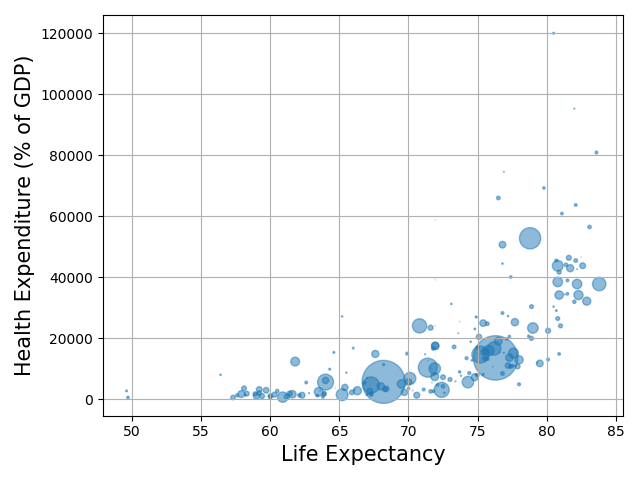

In [27]:
%matplotlib notebook

fig, ax = plt.subplots()

tmp = df_latest.loc[df_latest['population'].notnull()]

pop = tmp['population']
pop = 1024 * (pop  - pop.min()) / (pop.max() - pop.min())

sc = ax.scatter(tmp['life_expectancy'], tmp['income'], s=pop, alpha=0.5)

ax.set_ylabel(r'Health Expenditure (% of GDP)', fontsize=15)
ax.set_xlabel(r'Life Expectancy', fontsize=15)

ax.grid(True)
fig.tight_layout()

annot = ax.annotate("", xy=(0,0), xytext=(0,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = ", ".join([tmp.index[n] for n in ind["ind"]])
    annot.set_text(text)
    #annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

In [21]:
%matplotlib inline

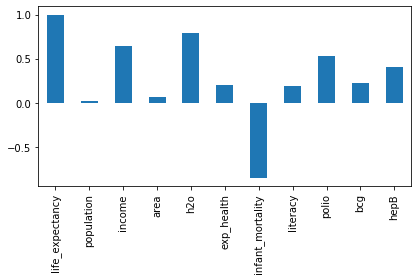

In [22]:
fig, ax = plt.subplots()

corr = df_latest.corr()['life_expectancy']
corr.plot.bar()

plt.tight_layout()
plt.show()

In [23]:
#tmp = df.loc[:, ('population', years)].droplevel(level=0, axis=1)
#display(tmp)
#display(df.loc[df.loc[:, ('life_expectancy', years)].idxmin(), ('life_expectancy', years)])

In [24]:
inputs = ['h2o', 'income', 'exp_health', 'literacy', 'polio', 'bcg', 'hepB']

x = df_latest[inputs].values
y = df_latest['life_expectancy'].values

#x = np.concatenate([df.loc[:, (inputs, i)].values for i in years])
#y = np.concatenate([df.loc[:, ('life_expectancy', i)].values for i in years])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print("Mean squared error equals: {0}".format(mean_squared_error(y_pred, y_test)))

Mean squared error equals: 20.700463613276213


In [25]:
h2o=w.FloatSlider(
    min=0.0, max=1.0, step=0.01,
    continuous_update=False,
    value=df_latest['h2o'].mean(),
    description='Access to fresh water'
)
income=w.IntSlider(
    min=0, max=df_latest['income'].max() * 1.5,
    continuous_update=False,
    value=df_latest['income'].mean(),
    description='GDP'
)
exp_health=w.FloatSlider(
    min=0, max=1.0, step=0.01,
    continuous_update=False,
    value=df_latest['exp_health'].mean(),
    description='Health expenditure (% GDP)'
)
literacy=w.FloatSlider(
    min=0.0, max=1.0, step=0.01,
    continuous_update=False,
    value=df_latest['literacy'].mean(),
    description='Literacy'
)
polio=w.FloatSlider(
    min=0.0, max=1.0, step=0.1,
    continuous_update=False,
    value=df_latest['polio'].mean(),
    description='Polio immunization'
)
bcg=w.FloatSlider(
    min=0.0, max=1.0, step=0.1,
    continuous_update=False,
    value=df_latest['bcg'].mean(),
    description='BCG immunization'
)
hepB=w.FloatSlider(
    min=0.0, max=1.0, step=0.1,
    continuous_update=False,
    value=df_latest['hepB'].mean(),
    description='HepB immunization'
)
country=w.Dropdown(
    options=df_latest.index,
    continuous_update=False,
    value='Poland'
)
year=w.IntSlider(
    min=min(years), max=max(years),
    continuous_update=False,
    value=max(years)
)

@interact(country=country, year=year)
def country_selector(country, year):
    #year = str(year)
    data = df.loc[country].xs(str(year), level=1)
    h2o.value = data['h2o']
    income.value = data['income']
    exp_health.value = data['exp_health']
    literacy.value = data['literacy']
    polio.value = data['polio']
    bcg.value = data['bcg']
    hepB.value = data['hepB']

@interact(
    h2o=h2o,
    income=income,
    exp_health=exp_health,
    literacy=literacy,
    polio=polio,
    bcg=bcg,
    hepB=hepB
)
def predict(**kwargs):
    tmp = np.array([[*kwargs.values()]])
    tmp = np.array([[kwargs[x] for x in inputs]])
    prediction = model.predict(tmp)[0]
    display("%.2f" % prediction)

interactive(children=(Dropdown(description='country', index=133, options=('Afghanistan', 'Albania', 'Algeria',…

interactive(children=(FloatSlider(value=0.9790000000000001, continuous_update=False, description='Access to fr…